In [1]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import re
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import networkx.algorithms.community as comms


In [2]:
DATA = '../Data/out.moreno_crime_crime'
ROLE = '../Data/rel.moreno_crime_crime.person.role'
NAME = '../Data/ent.moreno_crime_crime.person.name'
SEX =  '../Data/ent.moreno_crime_crime.person.sex'

In [3]:
with open(DATA) as f:
    data = f.read().splitlines()
    
with open(ROLE) as f:
    role = f.read().splitlines()
    
with open(NAME) as f:
    name = f.read().splitlines()
    
with open(SEX) as f:
    sex = f.read().splitlines()

graph = np.loadtxt(DATA, dtype=str) 

for i in graph:
    if len(i[0]) == 1:
        i[0] = '00' + i[0]
    elif len(i[0]) == 2:
        i[0] = '0' + i[0]
    #else:
        #i[0] = '' + i[0]
for i in graph:        
    if len(i[1]) == 1:
        i[1] = '00' + i[1]
    elif len(i[1]) == 2:
        i[1] = '0' + i[1]
    
df = pd.DataFrame(graph)
df.columns = ["person", "crime"]
df["person"] = 'p' + df['person'] 
df.head()

,person,crime
0,p001,001
1,p001,002
2,p001,003
3,p001,004
4,p002,005


In [4]:
df_names = pd.DataFrame(name, columns = ['Name'])

df_names[814:815]

,Name
814,WillisJenny


In [5]:
lasts = []
firsts = []
for n in name:
    lasts.append((re.findall('[A-Z][^A-Z]*', n))[0])
    firsts.append((re.findall('[A-Z][^A-Z]*', n))[1])

In [6]:
#Read in graph and find and isolate the greatest connected component
edges = [e for e in zip(df['person'], df['crime'])]

print(graph)
        
a = np.unique(graph[:,0]) # people nodes
b = np.unique(graph[:,1]) # crime nodes
a = ['p' + a for a in a] # add string to differentiate

print(len(a), len(b))

G = nx.Graph()

# add nodes
for j in range(len(a)):
    G.add_node(a[j], bipartite=0, data=True, first=firsts[j], last=lasts[j], name=name[j], sex=sex[j], Community = []) #Add attributes name and sex

G.add_nodes_from(b, bipartite=1, data=True)



# add edges
i = 0
for edge in edges:
    G.add_edge(edge[0], edge[1], role=role[i])
    i+=1

print(G.nodes['p336'])
    
p_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0} # people
c_nodes = set(G) - p_nodes # crimes

# components in the graph sorted in descendent order
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
# selecting the biggest component
G0 = G.subgraph(Gcc[0])
G.edges('p425')

[['001' '001']
 ['001' '002']
 ['001' '003']
 ...
 ['827' '265']
 ['828' '298']
 ['829' '271']]
829 551
{'bipartite': 0, 'data': True, 'first': 'Liz', 'last': 'Hall', 'name': 'HallLiz', 'sex': '0', 'Community': []}


EdgeDataView([('p425', '043'), ('p425', '095'), ('p425', '426'), ('p425', '427'), ('p425', '428'), ('p425', '429'), ('p425', '218'), ('p425', '059'), ('p425', '430'), ('p425', '417'), ('p425', '096'), ('p425', '235'), ('p425', '431'), ('p425', '110'), ('p425', '419'), ('p425', '432'), ('p425', '317'), ('p425', '094')])

In [7]:
G.nodes['p815']

{'bipartite': 0,
 'data': True,
 'first': 'Jenny',
 'last': 'Willis',
 'name': 'WillisJenny',
 'sex': '0',
 'Community': []}

P 754 2127


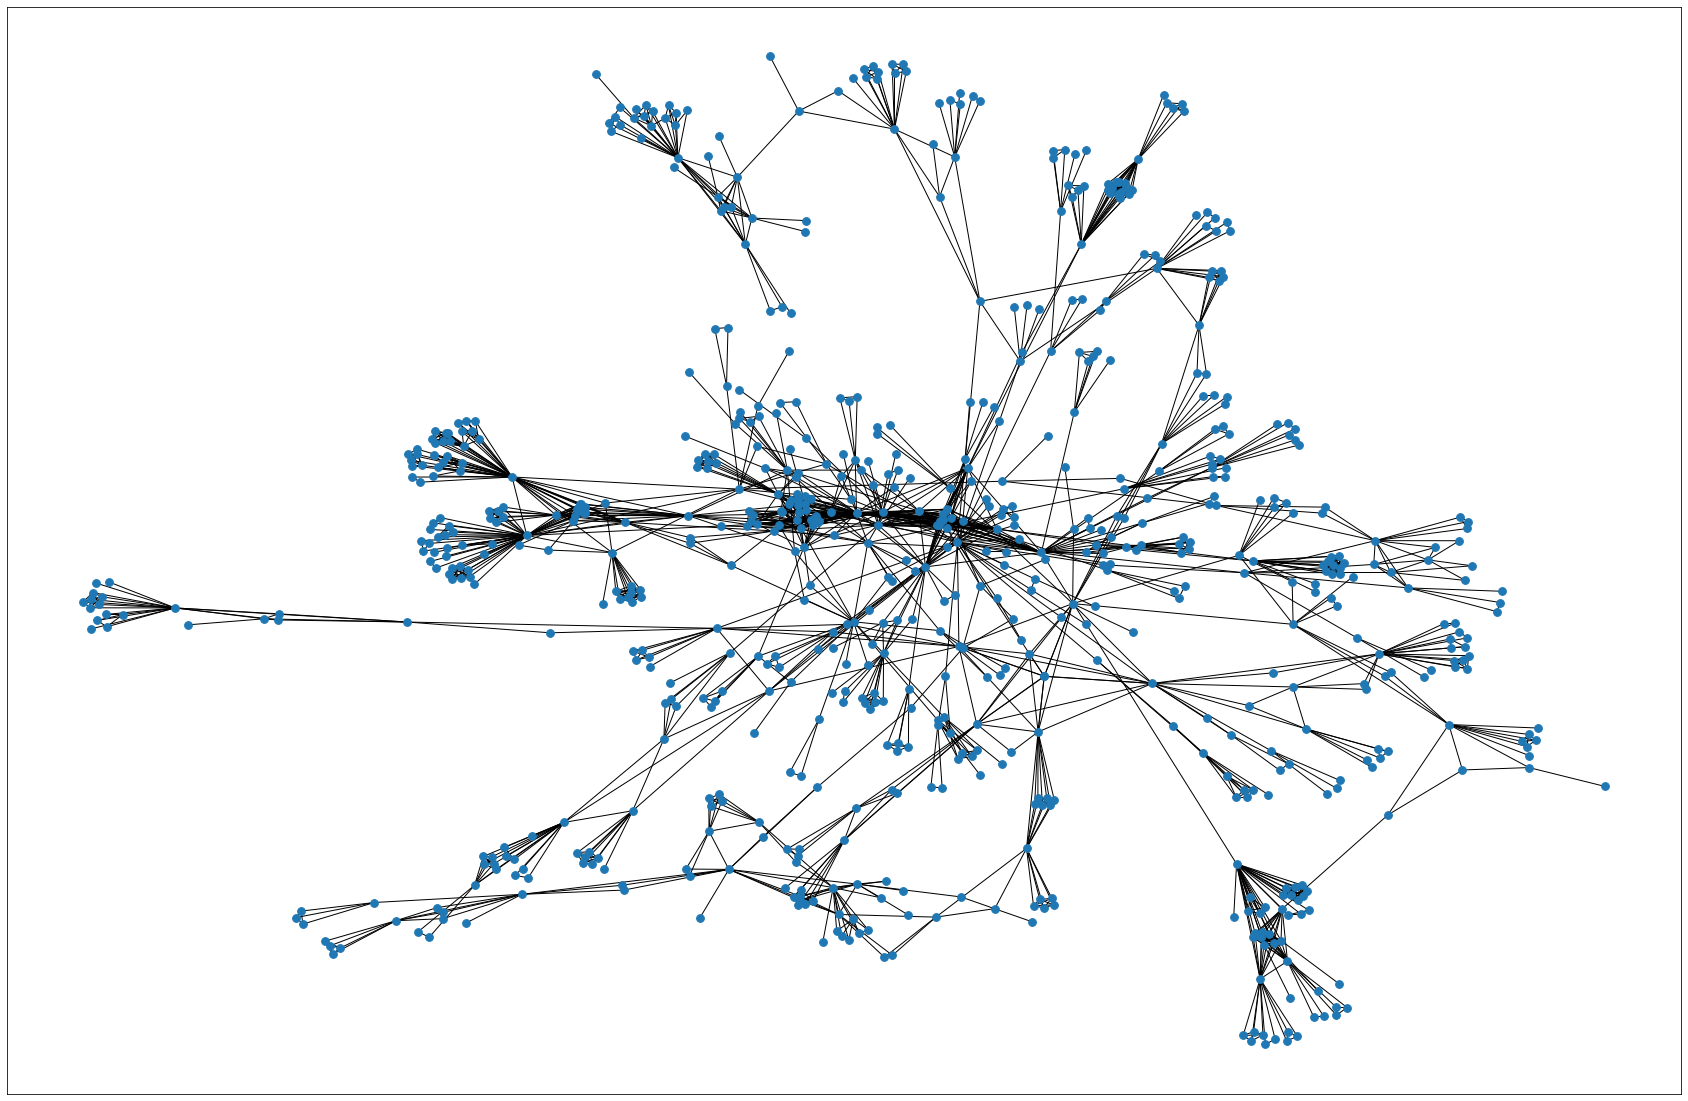

In [8]:
#Seperate the nodes for People and Crimes
p_nodes_gcc = {n for n, d in G0.nodes(data=True) if d["bipartite"] == 0}
c_nodes_gcc = set(G0) - p_nodes_gcc

#print(len(p_nodes_gcc), len(c_nodes_gcc))

# project onto people and visualise
P = bipartite.weighted_projected_graph(G0, p_nodes_gcc)

print('P',len(P.nodes()), len(P.edges()))

plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(P, seed=23)

nx.draw_networkx(P, pos, node_size=60, with_labels=False)

In [9]:
# Initialize a dictionary based on people nodes to keep track of all roles per node
p_nodes = {el:[] for el in p_nodes_gcc}

# Add all the edge attributes to a dictionary of people nodes
for key,value in nx.get_edge_attributes(G, 'role').items():
    for part in key:
        if part in p_nodes_gcc:
            p_nodes[part].append(value)
#print(p_nodes)

# Initialize a dictionary to keep track of who is a "criminal"
criminals = {el:[] for el in p_nodes_gcc}

# Loop through all roles per node, and deem them criminals if ever they have been a suspect
for key in p_nodes:
    for value in p_nodes[key]:
        if value == "Suspect":
            criminals[key] = "Criminal"
            break
        elif value == "Victim Suspect":
            criminals[key] = "Criminal"
            break
        else:
            criminals[key] = "Innocent"

# Convert to pandas df
criminals_df = pd.DataFrame(criminals.items(), columns=['node', 'Criminal_Status'])

# loop through rows in the data frame and add the attribute of Criminal Status
for index, row in criminals_df.iterrows():
    #print(row['node'])
    G.nodes[row['node']]['Criminal_Status'] = row['Criminal_Status']
    
#criminals_df

In [10]:
bet_centrality = nx.betweenness_centrality(P, normalized = True, 
                                              endpoints = False)

In [11]:
bet_cent_list = sorted(bet_centrality.values(), reverse=True)

max(bet_centrality.values())

0.4228002367562995

In [12]:
for k,v in bet_centrality.items():
    if v == bet_cent_list[0]:
        print(f"POI is set to '{k}'")
        POI = k

POI is set to 'p815'


In [13]:
#POI = 'p336' #set a Person of Interest if not using the highest betweeness centrality person

In [14]:
class Dunno:
    
    def __init__ (self, G, POI='p1', highlight=0, Gcc=True):
        
        if Gcc:
            comp_list = sorted(nx.connected_components(G), key=len, reverse=True)
            self.G = G.subgraph(comp_list[0])
            print(f'Using the largest connected component of the graph, with {len(self.G.nodes())} nodes')
        else:
            self.G = G
        self.POI = POI
        self.highlight = highlight
        self.communities = sorted(comms.greedy_modularity_communities(self.G, weight='weight'), key=len, reverse=True)
        self.modularity = comms.modularity(self.G, self.communities)
        self.p_nodes = []
        self.c_nodes = []
        for node in self.G.nodes:
            if 'p' in node:
                self.p_nodes.append(node)
            else:
                self.c_nodes.append(node)
                
        if len(self.c_nodes) == 0:
            self.proj = self.G
            self.isproj=True
            print('This graph only has people in it, no crimes')
        else:
            self.proj = bipartite.weighted_projected_graph(self.G, self.p_nodes)
            self.isproj=False
        
    def com_find(self, proj=False):
        if proj:
            self.communities = sorted(comms.greedy_modularity_communities(self.proj, weight='weight'), key=len, reverse=True)
            self.modularity = comms.modularity(self.proj, self.communities)
            
        print(f"There are {len(self.communities)} communities.")
        found = False
        for i in range(len(self.communities)):
            if self.POI in self.communities[i]:
                print(f'The POI is in community {i}')
                found = True
                self.highlight = i #sets the POI's community to be highlighted in graphs below
        if not found:
            print(f'POI not found in this component, highlight defaults to {highlight}')
    
    def com_plot(self, save=False, plot_st = 0, plot_end=100, fig=(20,15), col='blue'):
        a = min(plot_end, len(self.communities))
        b = a//5
        if b == 0:
            b=1
        
        fig, ax = plt.subplots(figsize=fig)
        fig.tight_layout()
        
        
        for i in range(plot_st,a): 
            com = self.proj.subgraph(self.communities[i])
            print(i, len(com.nodes), len(com.edges))

            plt.subplot(b,5,i+1)
            nx.draw_spring(com, node_size=40, node_color=col)
        if save:
            plt.savefig(f'../Figures/communities.jpg')
        
    def high_com(self, proj=False, hi_col = 'red', oth_col='blue', crime_col = 'green', save=False):
        node_col = []
        if proj:
            G = self.proj
        else:
            G = self.G
            
        for node in G.nodes():
            if node in self.c_nodes:
                node_col.append(crime_col)
            elif node in self.communities[self.highlight]:
                node_col.append(hi_col)
            else:
                node_col.append(oth_col)

        
        plt.rcParams.update({'figure.figsize': (30, 20)})
        pos = nx.spring_layout(G, seed=23)

        nx.draw_networkx(G, pos,
                         node_size=80,
                         node_color=node_col,
                         with_labels=False)
        
        hi_patch = mpatches.Patch(color=hi_col, label=f'Community {self.highlight}')
        oth_patch = mpatches.Patch(color=oth_col, label=f'All other nodes')
        cri_patch = mpatches.Patch(color=crime_col, label=f'Crime nodes')
        if len(c_nodes) > 0 and not proj:
            hand = [hi_patch, oth_patch, cri_patch]
        else: 
            hand = [hi_patch, oth_patch]
        plt.legend(handles=hand, fontsize='xx-large')
         
        if save:
            plt.savefig(f'../Figures/community_{self.highlight}_highlight.jpg')
            
    def labled_comm(self, POI_col='aqua', male_col='blue', 
                    female_col='magenta', crime_col='green',
                   vic_col='blue', sus_col='red',
                    wit_col='green', other_col='black', save=False):
        ed = []
        lab = {}
        hand1 = []
        hand2 = []
        
        POI_patch = mpatches.Patch(color=POI_col, label=f'POI node')
        male_patch = mpatches.Patch(color=male_col, label=f'Male node')
        female_patch = mpatches.Patch(color=female_col, label=f'Female node')
        crime_patch = mpatches.Patch(color=crime_col, label=f'Crime node')
        
        vic_line = mlines.Line2D([], [], color=vic_col, label='Victim role')
        sus_line = mlines.Line2D([], [], color=sus_col, label='Suspect role')
        wit_line = mlines.Line2D([], [], color=wit_col, label='Witness role')
        other_line = mlines.Line2D([], [], color=other_col, label='Dual role')
        
        for per in self.communities[self.highlight]:
            if 'p' in per:
                lab[per] = (f"{nx.get_node_attributes(self.G, 'first')[per]} {nx.get_node_attributes(self.G, 'last')[per]} \n({per})")
                if self.isproj == False:
                    for c in self.G.edges([per]):
                        ed.append(c[1])
                        lab[c[1]] = f'{c[1]}'
            else:
                lab[per] = f'{per}'

        for i in self.communities[self.highlight]:
            ed.append(i)
  
        nc = []
        ec = []

        hi = self.G.subgraph(ed)

        for node in hi:
            if node in self.c_nodes:
                nc.append(crime_col)
                hand1.append(crime_patch)
            elif node in self.communities[self.highlight]:
                if node == POI:
                    nc.append(POI_col)
                    hand1.append(POI_patch)
                elif nx.get_node_attributes(self.G, 'sex')[node] == '1':
                    nc.append(male_col)
                    hand1.append(male_patch)
                else:
                    nc.append(female_col)
                    hand1.append(female_patch)
            else:
                nc.append('yellow') #none should ever show yellow!! something is wrong if they do
        
        if self.isproj==False:
            for edge in hi.edges():
                a = nx.get_edge_attributes(hi, 'role')[edge]
                if a == 'Victim':
                    ec.append(vic_col)
                    hand2.append(vic_line)
                elif a == 'Suspect':
                    ec.append(sus_col)
                    hand2.append(sus_line)
                elif a == 'Witness':
                    ec.append(wit_col)
                    hand2.append(wit_line)
                else:
                    ec.append(other_col)
                    hand2.append(other_line)
        else:
            ec = other_col

        hand = list(set(hand1)) + (list(set(hand2)))
        plt.rcParams.update({'figure.figsize': (25, 25)})
        pos = nx.spring_layout(hi, weight=None, k=0.2, seed=23)

        nx.draw_networkx(hi, pos, node_size=200, node_color=nc, edge_color=ec, labels=lab)
        plt.legend(handles=hand, fontsize='xx-large')
        if save:
            plt.savefig(f'../Figures/community_{self.highlight}_focus.jpg')



Using the largest connected component of the graph, with 1263 nodes
There are 31 communities.
The POI is in community 2


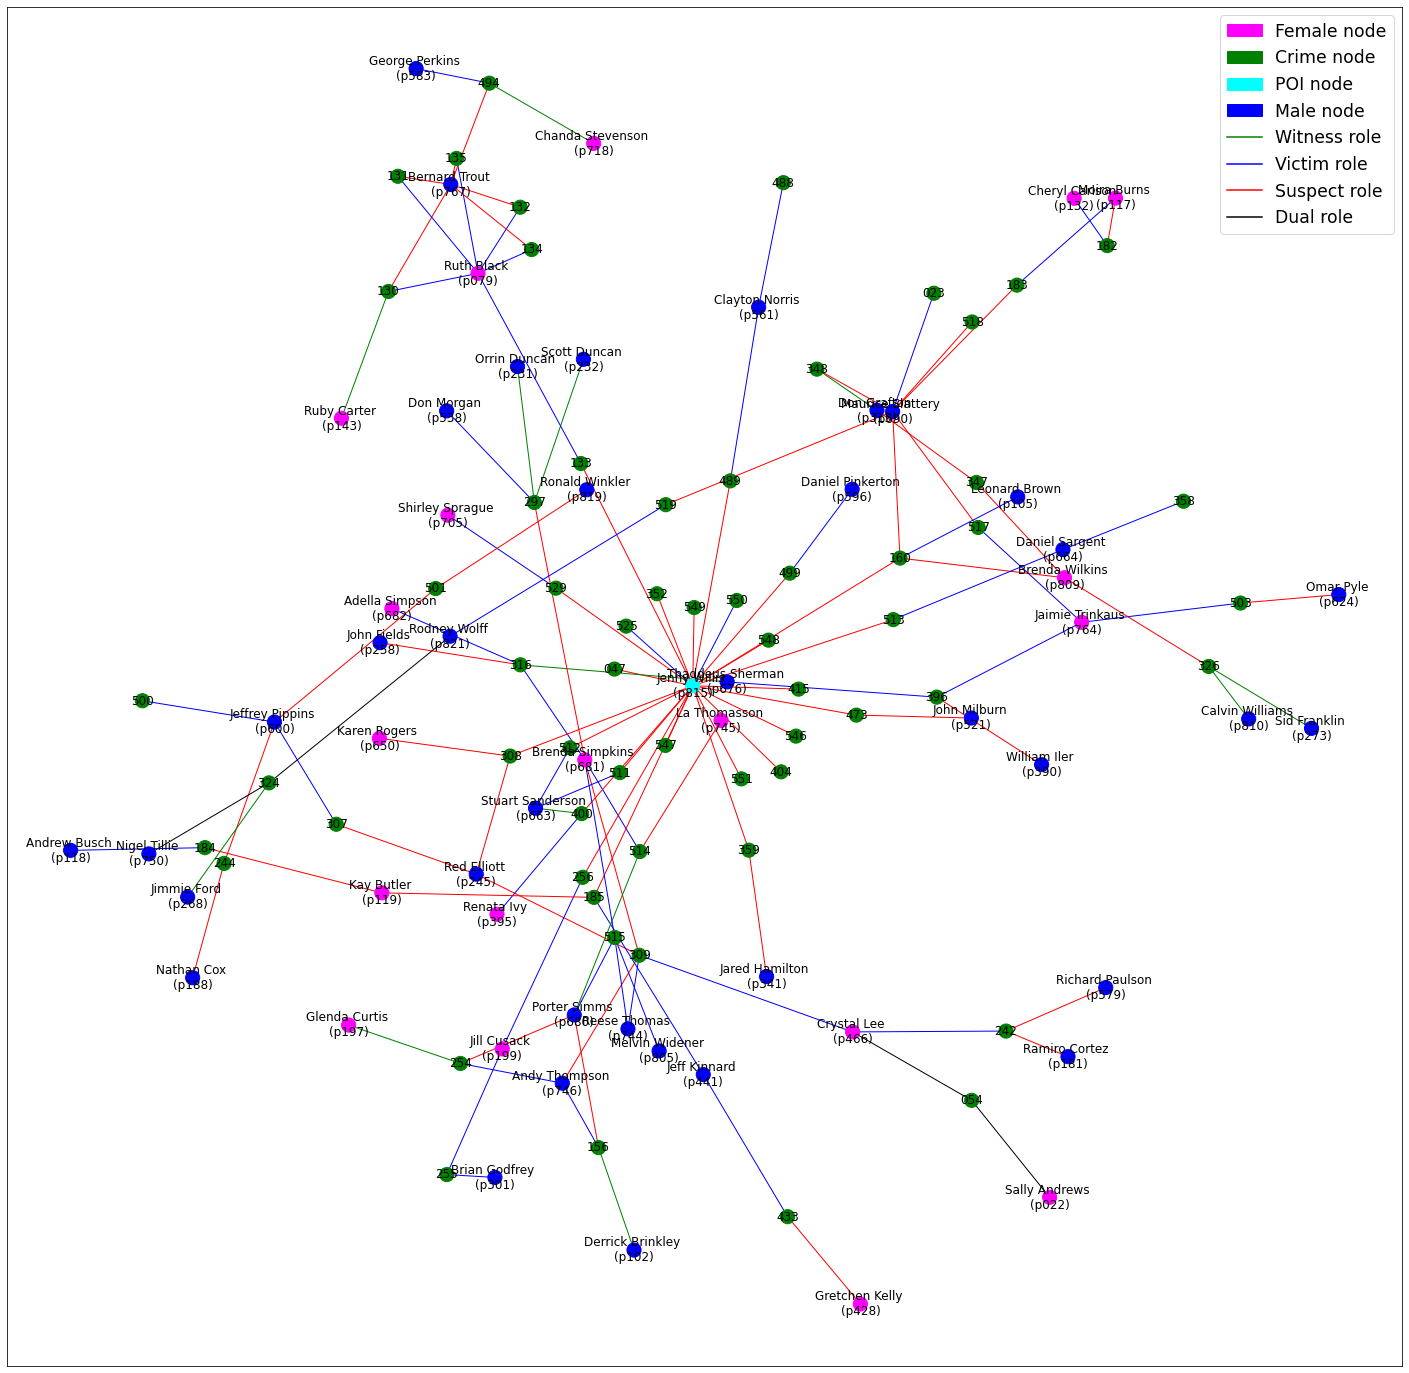

In [15]:
thing = Dunno(G, POI) #will default to using the largest connected component unless you state Gcc=False

thing.com_find(proj=True) #set proj=True if you want to find communities for the people projection, else it will use the entire graph you gave it. 
#Once projection is set to true, it overwrites the communities from the entire graph, so it will always be working on the projection.
#print(f'Modularity of network communities: {thing.modularity}')
#thing.com_plot(plot_end=10, col='blue') 

#thing.high_com(hi_col='magenta',oth_col='aqua',) #use proj=True to draw the projected graph, or defaults to drawing the whole graph
thing.labled_comm()

In [16]:
for edge in thing.proj.edges():
    if nx.get_edge_attributes(thing.proj, 'weight')[edge] > 1:
        print(edge, nx.get_edge_attributes(thing.proj, 'weight')[edge])


('p002', 'p033') 2
('p002', 'p067') 4
('p002', 'p338') 2
('p002', 'p356') 2
('p002', 'p361') 2
('p010', 'p225') 2
('p010', 'p568') 2
('p017', 'p514') 4
('p037', 'p326') 2
('p037', 'p797') 3
('p045', 'p356') 2
('p051', 'p074') 2
('p054', 'p425') 3
('p056', 'p412') 2
('p056', 'p057') 2
('p056', 'p303') 3
('p057', 'p303') 2
('p057', 'p058') 2
('p073', 'p097') 2
('p073', 'p497') 2
('p079', 'p767') 5
('p087', 'p659') 4
('p088', 'p089') 2
('p097', 'p497') 2
('p112', 'p511') 2
('p114', 'p497') 2
('p115', 'p633') 2
('p128', 'p533') 2
('p128', 'p531') 5
('p129', 'p155') 2
('p155', 'p174') 2
('p159', 'p284') 2
('p214', 'p216') 2
('p220', 'p729') 2
('p242', 'p398') 2
('p291', 'p812') 2
('p333', 'p592') 3
('p344', 'p696') 3
('p356', 'p731') 2
('p356', 'p793') 2
('p356', 'p418') 2
('p365', 'p497') 2
('p396', 'p531') 3
('p404', 'p437') 2
('p404', 'p405') 2
('p404', 'p415') 2
('p410', 'p686') 2
('p413', 'p715') 2
('p413', 'p497') 2
('p413', 'p695') 3
('p413', 'p425') 4
('p425', 'p715') 5
('p425', 'p4

Criminal p815


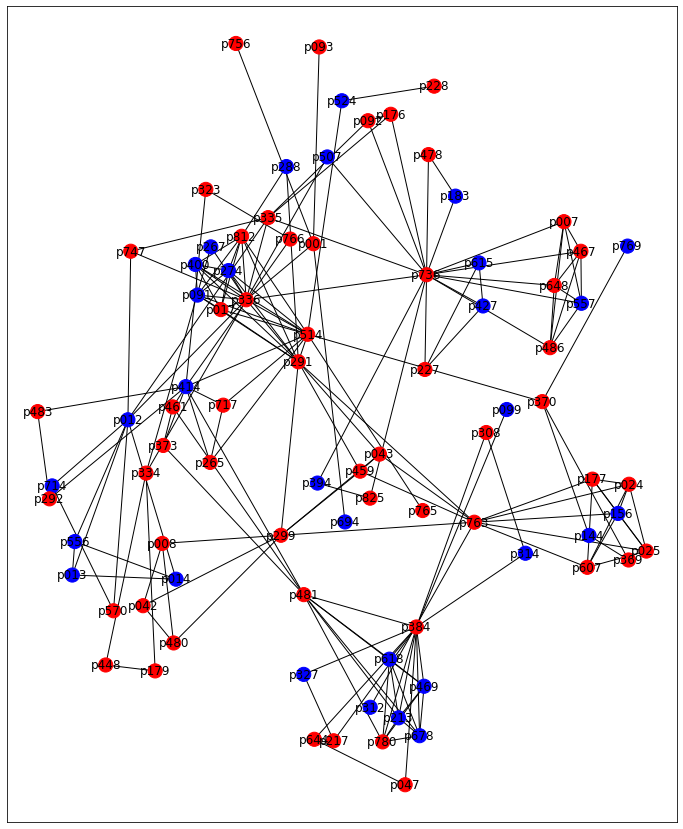

In [17]:
sub = nx.subgraph(thing.proj, thing.communities[1])
node_col = []

for node in sub.nodes():
    a = nx.get_node_attributes(G, 'Criminal_Status')[node]
    if a == 'Criminal':
        if node == POI:
            node_col.append('magenta')
        else:
            node_col.append('red')
    else:
        if node == POI:
            node_col.append('cyan')
        else:
            node_col.append('blue')

plt.rcParams.update({'figure.figsize': (12, 15)})
pos = nx.spring_layout(sub, weight=None, k=0.5, seed=23)

nx.draw_networkx(sub, pos, node_size=200, node_color=node_col)
print(nx.get_node_attributes(G, 'Criminal_Status')[POI], POI)

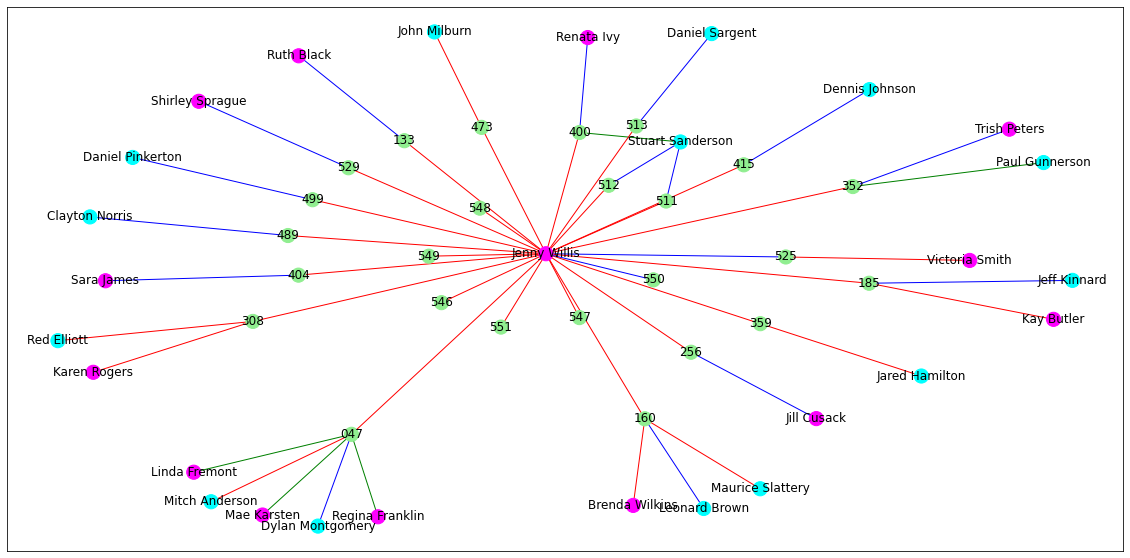

In [18]:
POI_G = nx.Graph()
POI_edges = []
nc = []
ec = []
lab = {}

for edge in G.edges():
    if POI in edge:
        POI_edges.append(edge)

for e in POI_edges:
    #print(e[1])
    POI_G.add_edges_from(G.edges(e[1]))

for node in POI_G:
    if node in p_nodes_gcc:
        if nx.get_node_attributes(G, 'sex')[node] == '1':
            nc.append('aqua')
        else:
            nc.append('magenta')
        lab[node] = (f"{nx.get_node_attributes(G, 'first')[node]} {nx.get_node_attributes(G, 'last')[node]}")
    elif node in c_nodes_gcc:
        nc.append('lightgreen')
        lab[node] = node
    else:
        nc.append('yellow') #none should ever show yellow!! something is wrong if they do
    
        
for edge in POI_G.edges():
    try:
        a = nx.get_edge_attributes(G, 'role')[edge]
    except:
        a = nx.get_edge_attributes(G, 'role')[(edge[1], edge[0])]
    if a == 'Victim':
        ec.append('blue')
    elif a == 'Suspect':
        ec.append('red')
    elif a == 'Witness':
        ec.append('green')
    else:
        ec.append('black')


a_nodes = POI_G.nodes()

        
plt.rcParams.update({'figure.figsize': (20, 10)})
pos = nx.spring_layout(POI_G, seed=13)

nx.draw_networkx(POI_G, pos, node_size=200, node_color=nc, edge_color=ec, labels=lab)

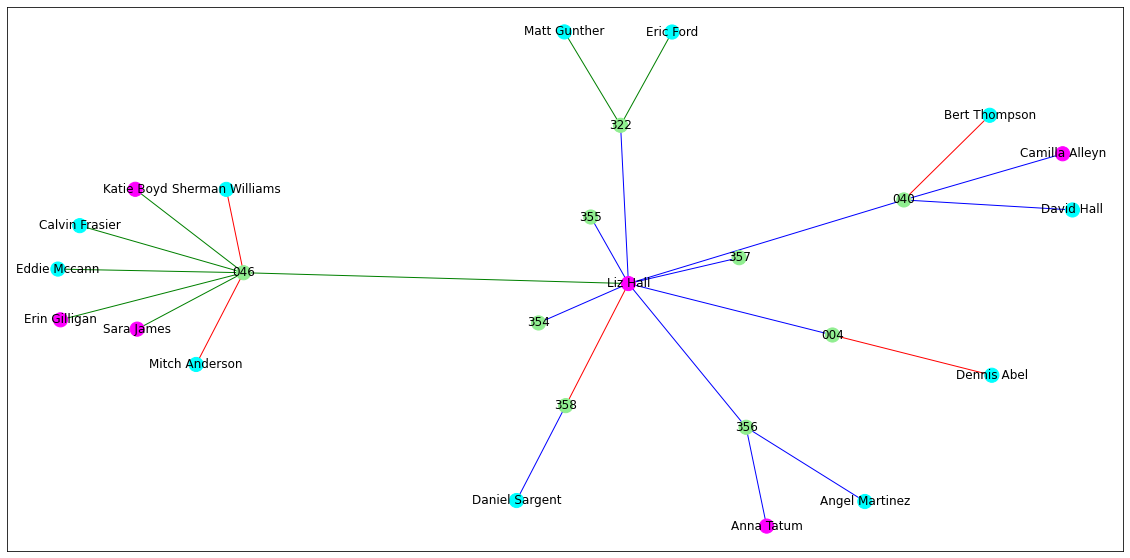

In [19]:
Sec_POI = 'p336'

POI_G = nx.Graph()
POI_edges = []
nc = []
ec = []
lab = {}

for edge in G.edges():
    if Sec_POI in edge:
        POI_edges.append(edge)

for e in POI_edges:
    #print(e[1])
    POI_G.add_edges_from(G.edges(e[1]))

for node in POI_G:
    if node in p_nodes_gcc:
        if nx.get_node_attributes(G, 'sex')[node] == '1':
            nc.append('aqua')
        else:
            nc.append('magenta')
        lab[node] = (f"{nx.get_node_attributes(G, 'first')[node]} {nx.get_node_attributes(G, 'last')[node]}")
    elif node in c_nodes_gcc:
        nc.append('lightgreen')
        lab[node] = node
    else:
        nc.append('yellow') #none should ever show yellow!! something is wrong if they do
    
        
for edge in POI_G.edges():
    try:
        a = nx.get_edge_attributes(G, 'role')[edge]
    except:
        a = nx.get_edge_attributes(G, 'role')[(edge[1], edge[0])]
    if a == 'Victim':
        ec.append('blue')
    elif a == 'Suspect':
        ec.append('red')
    elif a == 'Witness':
        ec.append('green')
    else:
        ec.append('black')


b_nodes = POI_G.nodes()

        
plt.rcParams.update({'figure.figsize': (20, 10)})
pos = nx.spring_layout(POI_G, seed=13)

nx.draw_networkx(POI_G, pos, node_size=200, node_color=nc, edge_color=ec, labels=lab)

In [20]:
a_nodes

NodeView(('511', 'p663', 'p815', '513', 'p664', '529', 'p705', '546', '308', 'p245', 'p650', '489', 'p561', '473', 'p521', '525', 'p696', '400', 'p395', '133', 'p079', '359', 'p341', '185', 'p119', 'p441', '047', 'p017', 'p272', 'p277', 'p424', 'p536', '547', '548', '352', 'p333', 'p592', '549', '499', 'p596', '550', '551', '404', 'p400', '512', '160', 'p105', 'p690', 'p809', '415', 'p411', '256', 'p199'))

In [21]:
b_nodes

NodeView(('040', 'p012', 'p335', 'p336', 'p747', '354', '322', 'p267', 'p334', '355', '356', 'p507', 'p736', '357', '046', 'p017', 'p091', 'p274', 'p291', 'p400', 'p514', 'p812', '358', 'p664', '004', 'p001'))

In [22]:
neighbours = []

for node in a_nodes:
    if node in b_nodes:
        print(node, G.nodes[node]['first'], G.nodes[node]['last'], G.nodes[node]['Community'])
        neighbours.append(node)

p664 Daniel Sargent []
p017 Mitch Anderson []
p400 Sara James []


## Look at suspects only:

In [23]:
sus_edge = []
sus_nodes = []
for edge in G.edges():
    if nx.get_edge_attributes(G, 'role')[edge] == 'Suspect':
        sus_edge.append(edge)
        sus_nodes.append(edge[0])
       

len(set(sus_nodes)),len(sus_edge)

(412, 682)

818
107
Scc length 156
48 59


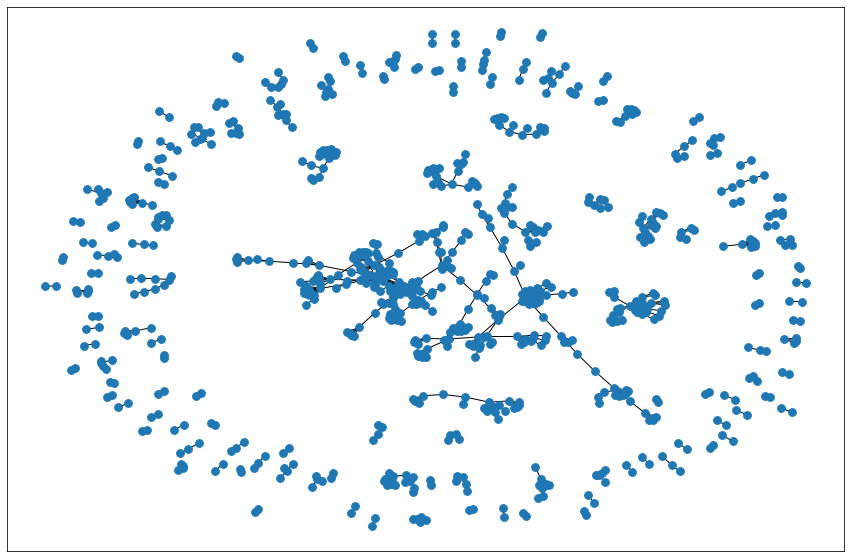

In [24]:
#S = G.subgraph(sus_nodes)
S = nx.Graph()

for n in sus_nodes:
    S.add_node(n, bipartite=0, data=True)
    
for e in sus_edge:
    #print(e)
    S.add_node(e[1], bipartite=1, data=True)

S.add_edges_from(sus_edge)
#print(sus_edge)
print(len(S.nodes()))
Scc = sorted(nx.connected_components(S), key=len, reverse=True)
# selecting the biggest component
print(len(Scc[0])) #p815 in Scc[2]
S0 = S.subgraph(Scc[0])
print('Scc length', len(Scc))

p_nodes_scc = {n for n, d in S0.nodes(data=True) if d["bipartite"] == 0}
c_nodes_scc = set(S0) - p_nodes_scc

print(len(p_nodes_scc), len(c_nodes_scc))

plt.rcParams.update({'figure.figsize': (15, 10)})
pos = nx.spring_layout(S, seed=23)

nx.draw_networkx(S, pos, node_size=60, with_labels=False)

Sp 48 207


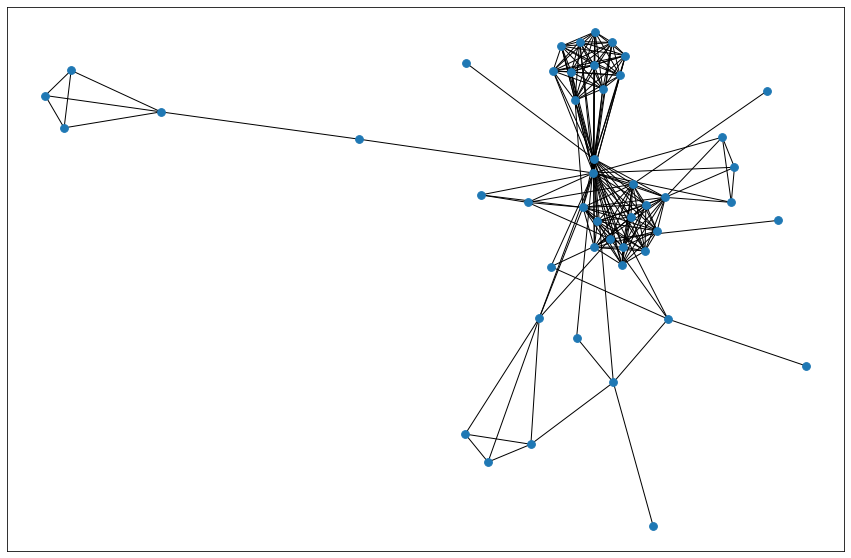

In [25]:
# project onto people and visualise
Sp = bipartite.weighted_projected_graph(S0, p_nodes_scc)

print('Sp',len(Sp.nodes()), len(Sp.edges()))

#Suspects only largest connected component
plt.rcParams.update({'figure.figsize': (15, 10)})
pos = nx.spring_layout(Sp, seed=23)

nx.draw_networkx(Sp, pos, node_size=60, with_labels=False)

In [26]:
communities_sp = sorted(comms.greedy_modularity_communities(Sp), key=len, reverse=True) #17 coms modularity 0.770
#communities_sp = sorted(comms.label_propagation_communities(Sp), key=len, reverse=True) #54 coms modularity 0.745

# Count the communities
print(f"There are {len(communities_sp)} communities.")


for i in range(len(communities_sp)):
    if POI in communities_sp[i]:
        print(f'The POI ({POI}) is in community {i}')
        highlight = i #sets the POI's community to be highlighted in graphs below
    else:
        highlight = 0

There are 4 communities.


0 23
1 16
2 5
3 4


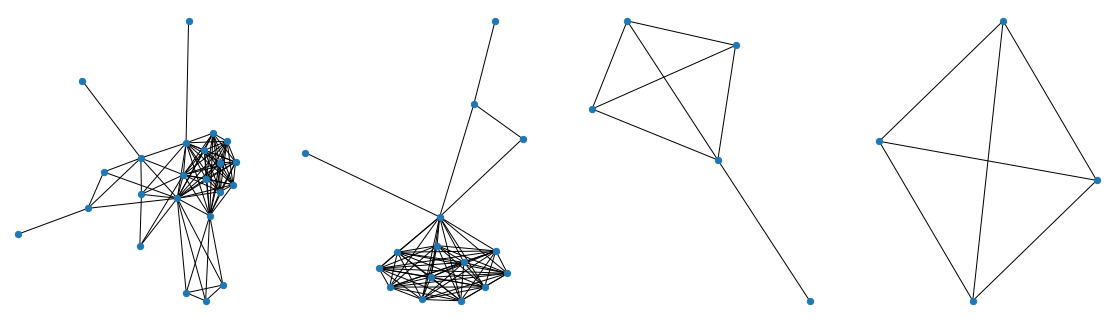

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
fig.tight_layout()

for i in range(0,len(communities_sp)): 
    com = Sp.subgraph(communities_sp[i])
    print(i, len(com.nodes))
    plt.subplot(2,5,i+1)
    nx.draw_spring(com, node_size=40) #, with_labels=True
#plt.savefig(f'../Figures/1-10_Sp_community.jpg')

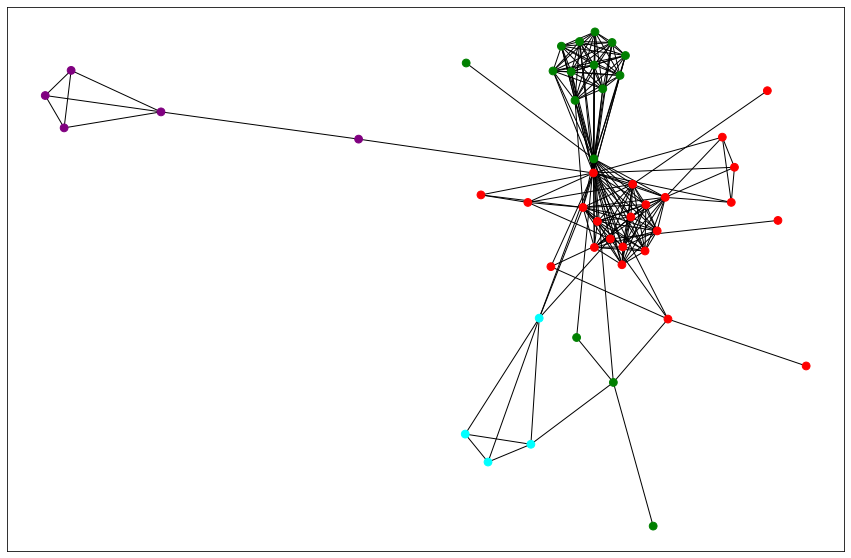

In [28]:
highlight = 1 #choose a community to highlight via it's index in the communities list

node_col = []

for node in Sp.nodes():
    if node in communities_sp[0]:
        node_col.append('red')
    elif node in communities_sp[1]:
        node_col.append('green')
    elif node in communities_sp[2]:
        node_col.append('purple')
    elif node in communities_sp[3]:
        node_col.append('aqua')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (15, 10)})
pos = nx.spring_layout(Sp, seed=23)

nx.draw_networkx(Sp, pos, node_size=60, node_color=node_col, with_labels=False)

#plt.savefig(f'../Figures/community_{highlight}_people_projection.jpg')

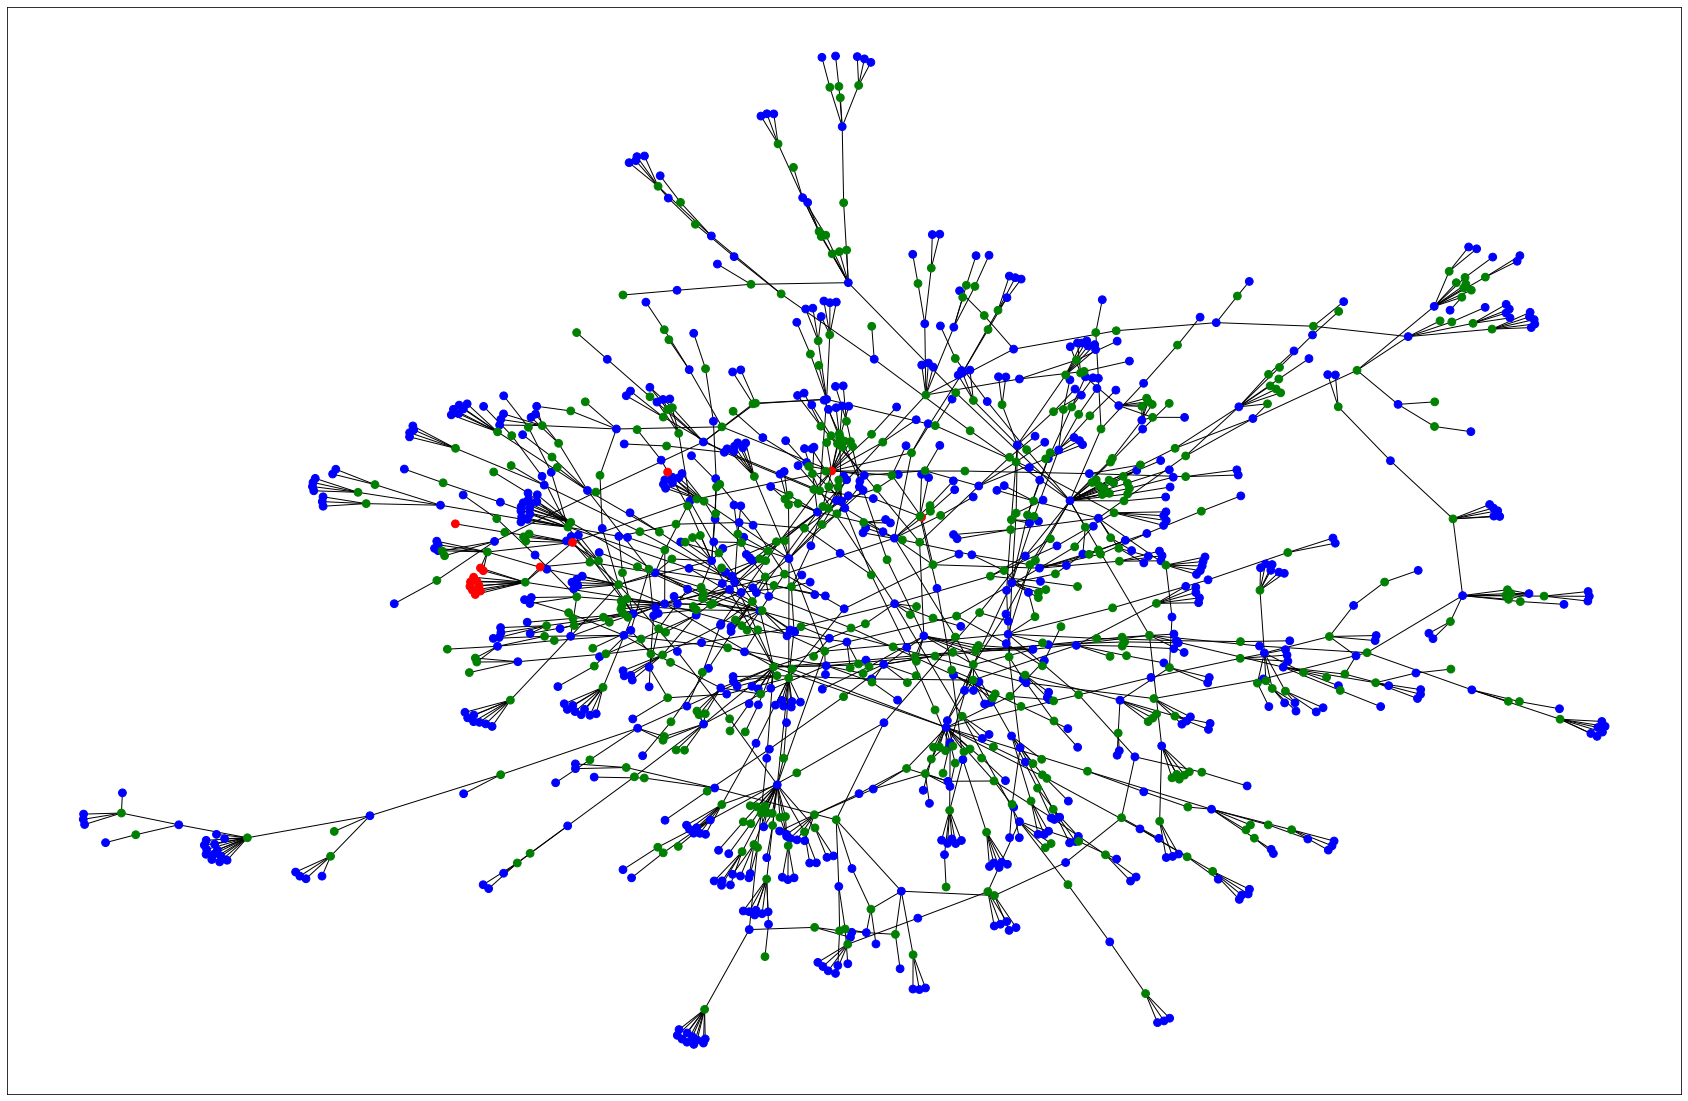

In [29]:
node_col = []

for node in G0.nodes():
    if node in communities_sp[highlight]:
        node_col.append('red')
    elif node in c_nodes_gcc:
        node_col.append('green')
    else:
        node_col.append('blue')


plt.rcParams.update({'figure.figsize': (30, 20)})
pos = nx.spring_layout(G0, seed=23)

nx.draw_networkx(G0, pos, node_size=60, node_color=node_col, with_labels=False)

#plt.savefig(f'../Figures/community_{highlight}_lcc_no projection.jpg')

In [30]:
ed = []
lab = {}

for per in communities_sp[highlight]:
    print('\n------\n\n',nx.get_node_attributes(G, 'first')[per], nx.get_node_attributes(G, 'last')[per], nx.get_node_attributes(G, 'sex')[per])
    lab[per] = (f"{nx.get_node_attributes(G, 'first')[per]} {nx.get_node_attributes(G, 'last')[per]}", per)
    for c in G.edges([per]):
        if nx.get_edge_attributes(G0, 'role')[c] == 'Suspect':
            print(c, nx.get_edge_attributes(G0, 'role')[c])
            ed.append(c[1])
            lab[c[1]] = f'{c[1]}'
        
for i in communities_sp[highlight]:
    ed.append(i)


------

 Greg Courtland 1
('p185', '043') Suspect

------

 Ginny Gootschalk 0
('p306', '043') Suspect

------

 Roger West 1
('p795', '043') Suspect

------

 Ricky Farmer 1
('p250', '043') Suspect

------

 Manuel Brass 1
('p097', '043') Suspect

------

 Daron Amada 1
('p015', '043') Suspect

------

 Bradley Marcus 1
('p497', '454') Suspect
('p497', '455') Suspect
('p497', '456') Suspect
('p497', '043') Suspect
('p497', '095') Suspect
('p497', '383') Suspect
('p497', '210') Suspect
('p497', '287') Suspect

------

 Freddie Carter 1
('p142', '210') Suspect

------

 Carlton Billups 1
('p073', '043') Suspect

------

 Conor Omalley 1
('p566', '043') Suspect

------

 Robert Stone 1
('p725', '287') Suspect

------

 Jeremiah Cooper 1
('p178', '043') Suspect

------

 Jason Herbert 1
('p365', '043') Suspect
('p365', '383') Suspect

------

 Coleman Flanders 1
('p264', '282') Suspect

------

 Ambrose Poole 1
('p606', '043') Suspect

------

 Carter Dickson 1
('p220', '272') Suspect
('

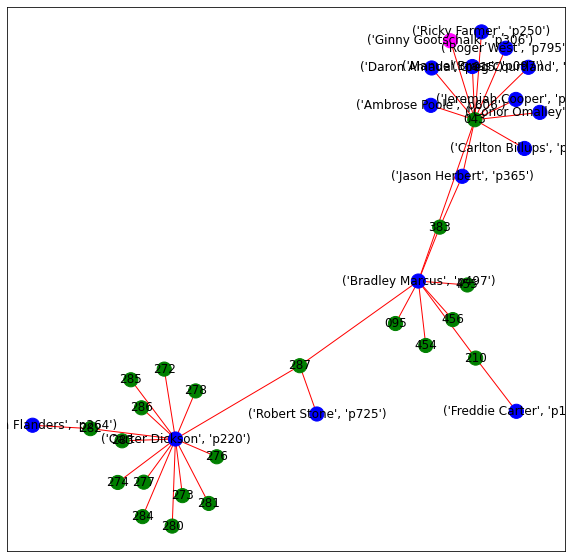

In [31]:
nc = []
ec = []

hi = G.subgraph(ed)

for node in hi:
    if node in communities_sp[highlight]:
        if nx.get_node_attributes(G, 'sex')[node] == '1':
            nc.append('blue')
        else:
            nc.append('magenta')
    elif node in c_nodes_gcc:
        nc.append('green')
    else:
        nc.append('yellow') #none should ever show yellow!! something is wrong if they do
        
for edge in hi.edges():
    a = nx.get_edge_attributes(hi, 'role')[edge]
    if a == 'Victim':
        ec.append('white')
    elif a == 'Suspect':
        ec.append('red')
    elif a == 'Witness':
        ec.append('white')
    else:
        ec.append('white')
        
        

plt.rcParams.update({'figure.figsize': (10, 10)})
pos = nx.spring_layout(hi, seed=23)

nx.draw_networkx(hi, pos, node_size=200, node_color=nc, edge_color=ec, labels=lab)

#plt.savefig(f'../Figures/community_{highlight}_focus_labelled.jpg')

In [32]:
for c in communities_sp:
    peeps = []
    for p in c:
        peeps.append(nx.get_node_attributes(G, 'last')[p])
    print(len(c), len(peeps), len(set(peeps)))


23 23 22
16 16 16
5 5 5
4 4 3


In [33]:
Thi_POI = 'p301'
POI, Sec_POI, Thi_POI

('p815', 'p336', 'p301')

In [52]:
POI = 'p695'
Sec_POI = 'p715'

62
p695 1
p715 1
p695 4
p715 54
p695 55
p715 55
['p815', '047', 'p017', '046', 'p336']
['p815', '256', 'p199', '255', 'p301']


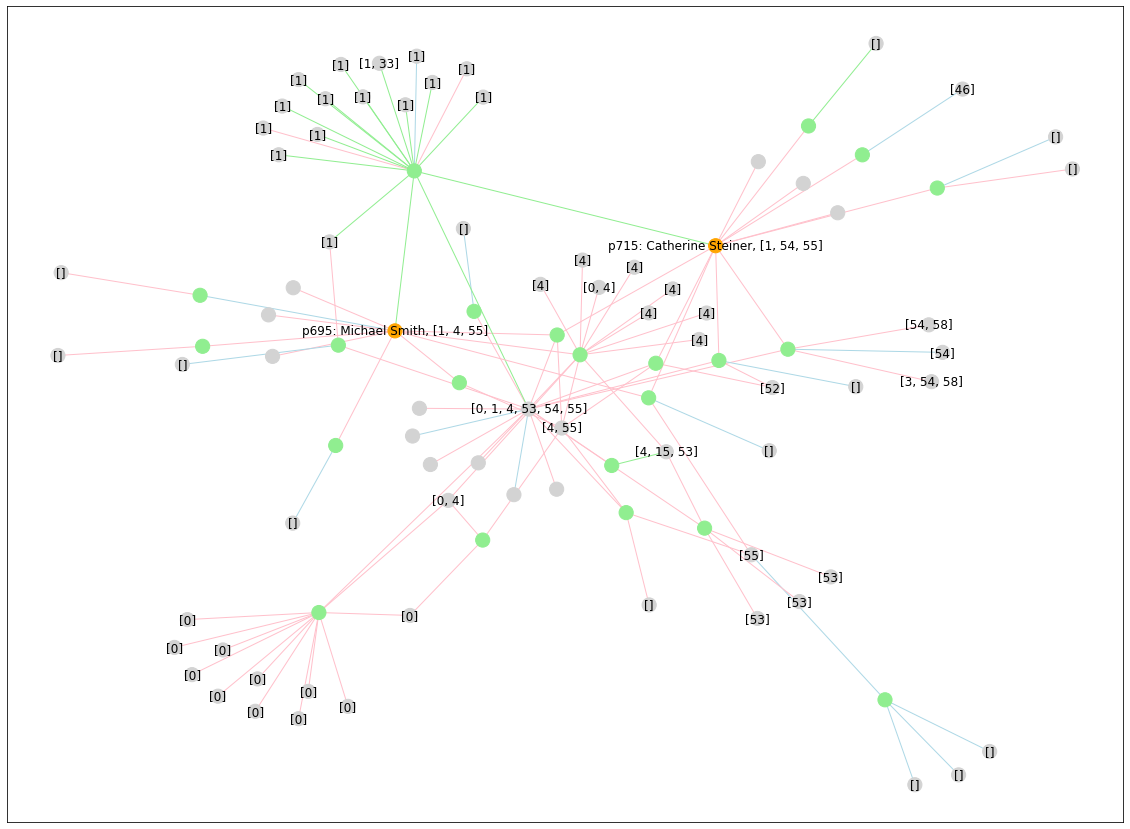

In [54]:
graph = np.loadtxt(DATA, dtype=str) 

for i in graph:
    if len(i[0]) == 1:
        i[0] = '00' + i[0]
    elif len(i[0]) == 2:
        i[0] = '0' + i[0]
    #else:
        #i[0] = '' + i[0]
for i in graph:        
    if len(i[1]) == 1:
        i[1] = '00' + i[1]
    elif len(i[1]) == 2:
        i[1] = '0' + i[1]
    
df = pd.DataFrame(graph)
df.columns = ["person", "crime"]
df["person"] = 'p' + df['person'] 

edges = [e for e in zip(df['person'], df['crime'])]


        
a = np.unique(graph[:,0]) # people nodes
b = np.unique(graph[:,1]) # crime nodes
a = ['p' + a for a in a] # add string to differentiate


G = nx.Graph()

# add nodes
for j in range(len(a)):
    G.add_node(a[j], bipartite=0, data=True, first=firsts[j], last=lasts[j], name=name[j], sex=sex[j], Community = []) #Add attributes name and sex

G.add_nodes_from(b, bipartite=1, data=True)



# add edges
i = 0
for edge in edges:
    G.add_edge(edge[0], edge[1], role=role[i])
    i+=1




    

cliques = list(nx.find_cliques(P))



c = list(comms.k_clique_communities(P,5, cliques = cliques))
x = sorted(list(c), key=len, reverse= True)
print(len(x))

for i in range(len(x)):
    if POI in x[i]:
        print(POI, i)
        co = i
    if Sec_POI in x[i]:
        print(Sec_POI, i)
        ot = i
'''    if Thi_POI in x[i]:
        print(Thi_POI, i)
        tt = i'''

POI_edges = []
nc = []
ec = []
lab = {}
x_ = list(x[co])
x__ = list(x[ot])
#x___ = list(x[tt])

for node in x_:
    for e in G.edges(node):
        POI_edges.append(e[1])
        for e in G.edges(e[1]):
            POI_edges.append(e[1])
    POI_edges.append(node)
    
for node in x__:
    for e in G.edges(node):
        POI_edges.append(e[1])
        for e in G.edges(e[1]):
            POI_edges.append(e[1])
    POI_edges.append(node)  

'''for node in x___:
    for e in G.edges(node):
        POI_edges.append(e[1])
        for e in G.edges(e[1]):
            POI_edges.append(e[1])
    POI_edges.append(node) '''
'''for e in G.edges(Thi_POI):
    POI_edges.append(e[1])
    for e in G.edges(e[1]):
        POI_edges.append(e[1])
POI_edges.append(Thi_POI)'''
    
#print(POI_edges)
    
POI_G = nx.subgraph(G, POI_edges)

a = 0
for community in x:
    #print(a, community)
    for v in community:
        G.nodes[v]['Community'].append(a)
    a+=1

'''pat = nx.shortest_path(G0, POI, Sec_POI)
n_list = [n for n in pat if 'p' in n]
e_list = []
for e in range(len(pat)-1):
    e_list.append((pat[e], pat[e+1]))
    e_list.append((pat[e+1], pat[e]))'''

'''pat2 = nx.shortest_path(G0, POI, Thi_POI)
n_list = [n for n in pat2 if 'p' in n]
for e in range(len(pat2)-1):
    e_list.append((pat2[e], pat2[e+1]))
    e_list.append((pat2[e+1], pat2[e]))'''

print(pat)
print(pat2)

#for n in n_list:
#    print('\n', n, G.nodes[n]['first'], G.nodes[n]['last'], G.nodes[n]['Community'])
    


for node in POI_G.nodes():
    #print(node)
    if node == POI:
        nc.append('orange')
        lab[node] = (f"{node}: {nx.get_node_attributes(G, 'first')[node]} {nx.get_node_attributes(G, 'last')[node]}, {nx.get_node_attributes(G, 'Community')[node]}")
    elif node == Sec_POI:
        nc.append('orange')
        lab[node] = (f"{node}: {nx.get_node_attributes(G, 'first')[node]} {nx.get_node_attributes(G, 'last')[node]}, {nx.get_node_attributes(G, 'Community')[node]}")
    elif node == Thi_POI:
        nc.append('orange')
        lab[node] = (f"{node}: {nx.get_node_attributes(G, 'first')[node]} {nx.get_node_attributes(G, 'last')[node]}, {nx.get_node_attributes(G, 'Community')[node]}")
    elif node in p_nodes_gcc:
        if co in nx.get_node_attributes(G, 'Community')[node]:
            if nx.get_node_attributes(G, 'sex')[node] == '1':
                nc.append('lightgrey')
                lab[node] = (f"{nx.get_node_attributes(G, 'Community')[node]}")
                #lab[node] = ''#(f"{node}: {nx.get_node_attributes(G, 'first')[node]} {nx.get_node_attributes(G, 'last')[node]}, {nx.get_node_attributes(G, 'Community')[node]}")
            else:
                nc.append('lightgrey')
                lab[node] = (f"{nx.get_node_attributes(G, 'Community')[node]}")
                #lab[node] = (f"{node}: {nx.get_node_attributes(G, 'first')[node]} {nx.get_node_attributes(G, 'last')[node]}, {nx.get_node_attributes(G, 'Community')[node]}")
        else:
            nc.append('lightgrey')
            lab[node] = (f"{nx.get_node_attributes(G, 'Community')[node]}")
    elif node in c_nodes_gcc:
        if POI_G.degree(node)>1:
            nc.append('lightgreen')
        else:    
            nc.append('lightgrey')
        lab[node] = ''#f'C{node}'
    else:
        nc.append('yellow')
    
        
for edge in POI_G.edges():
    try:
        a = nx.get_edge_attributes(G, 'role')[edge]
    except:
        a = nx.get_edge_attributes(G, 'role')[(edge[1], edge[0])]
    if edge in e_list:
        if a == 'Victim':
            ec.append('blue')
        elif a == 'Suspect':
            ec.append('red')
        elif a == 'Witness':
            ec.append('green')
        else:
            ec.append('grey')
        
    elif a == 'Victim':
        ec.append('lightblue')
    elif a == 'Suspect':
        ec.append('pink')
    elif a == 'Witness':
        ec.append('lightgreen')
    else:
        ec.append('white')




        
plt.rcParams.update({'figure.figsize': (20, 15)})
pos = nx.spring_layout(POI_G, seed=23, k=0.1)

nx.draw_networkx(POI_G, pos, node_size=200,node_color=nc,  edge_color=ec, labels=lab)
#plt.savefig(f'../Figures/communities_find__crimes.jpg')

In [36]:
neighbours = []

for node in a_nodes:
    if node in b_nodes:
        print(node, G.nodes[node]['first'], G.nodes[node]['last'], G.nodes[node]['Community'])
        neighbours.append(node)

p664 Daniel Sargent []
p017 Mitch Anderson [13, 32]
p400 Sara James [13]


In [37]:
for i in range(len(x)):
    print(f'Community {i}, length {len(list(x[i]))} nodes:\n')
    POI_G = nx.subgraph(P, list(x[i]))

    for node in sorted(POI_G.nodes()):
        print(node)
        for edge in G.edges([node]):
            print(edge[1], end = ', ')
        print('\n')

Community 0, length 18 nodes:

p006
028, 

p015
043, 

p073
028, 043, 

p097
028, 043, 

p114
028, 095, 

p178
043, 

p185
043, 

p250
043, 

p306
043, 

p365
043, 383, 

p425
043, 095, 426, 427, 428, 429, 218, 059, 430, 417, 096, 235, 431, 110, 419, 432, 317, 094, 

p497
454, 455, 028, 456, 043, 095, 383, 210, 287, 

p566
043, 

p595
028, 

p606
043, 

p647
028, 

p795
043, 

p803
028, 

Community 1, length 18 nodes:

p056
098, 099, 100, 101, 102, 103, 034, 104, 105, 106, 107, 108, 109, 110, 

p059
110, 

p074
123, 122, 124, 125, 090, 091, 110, 

p128
193, 194, 195, 196, 110, 197, 

p396
401, 093, 402, 188, 110, 

p425
043, 095, 426, 427, 428, 429, 218, 059, 430, 417, 096, 235, 431, 110, 419, 432, 317, 094, 

p531
474, 194, 195, 401, 475, 402, 196, 110, 197, 476, 

p533
198, 461, 196, 479, 360, 110, 

p572
460, 461, 479, 491, 492, 360, 110, 

p695
095, 521, 417, 260, 376, 418, 140, 522, 110, 523, 424, 

p715
531, 059, 417, 532, 490, 085, 140, 118, 533, 110, 419, 432, 

p743
110, 

p77

In [38]:
484/8.29, 345/8.29 #criminals vs innocent

(58.383594692400486, 41.61640530759952)

In [45]:
plt.rcParams.update({'figure.figsize': (10, 7)}) 

a= 0
overlap = []
notoverlap = []
none = []

for n in G0.nodes():
    if 'p' in n:
        if len(nx.get_node_attributes(G, 'Community')[n]) == 0:
            a+=1
            none.append(n)
        elif len(nx.get_node_attributes(G, 'Community')[n]) == 1:
            notoverlap.append(n)
        elif len(nx.get_node_attributes(G, 'Community')[n]) > 1:
            overlap.append(n)
            print(n, len(nx.get_node_attributes(G, 'Community')[n]), nx.get_node_attributes(G, 'Community')[n])
print(a)

p002 5 [3, 11, 14, 42, 45]
p010 3 [5, 8, 40]
p017 2 [13, 32]
p037 2 [31, 35]
p045 2 [37, 61]
p054 3 [4, 15, 53]
p056 2 [1, 33]
p057 2 [22, 33]
p062 2 [29, 48]
p114 2 [0, 4]
p219 2 [2, 60]
p291 2 [13, 59]
p294 2 [34, 47]
p304 2 [7, 45]
p343 2 [5, 49]
p356 7 [3, 9, 21, 37, 45, 57, 61]
p361 2 [3, 14]
p397 2 [2, 56]
p404 3 [10, 30, 44]
p413 2 [4, 55]
p418 2 [9, 61]
p425 6 [0, 1, 4, 53, 54, 55]
p439 3 [3, 54, 58]
p497 2 [0, 4]
p536 2 [32, 43]
p549 2 [19, 39]
p563 2 [3, 52]
p695 3 [1, 4, 55]
p715 3 [1, 54, 55]
p719 2 [12, 25]
p729 2 [54, 58]
p763 2 [24, 59]
p812 2 [12, 13]
376


p002 48 22 2.2
p010 28 8 3.5
p017 12 5 2.4
p037 16 8 2.0
p045 7 2 3.5
p054 22 4 5.5
p056 33 14 2.4
p057 10 3 3.3
p062 15 6 2.5
p114 18 2 9.0
p219 19 3 6.3
p291 12 7 1.7
p294 8 2 4.0
p304 14 4 3.5
p343 20 4 5.0
p356 44 11 4.0
p361 18 2 9.0
p397 20 4 5.0
p404 24 10 2.4
p413 17 6 2.8
p418 11 2 5.5
p425 51 18 2.8
p439 19 3 6.3
p497 30 9 3.3
p536 12 5 2.4
p549 17 7 2.4
p563 16 2 8.0
p695 33 11 3.0
p715 29 12 2.4
p719 14 3 4.7
p729 15 8 1.9
p763 10 4 2.5
p812 15 4 3.8


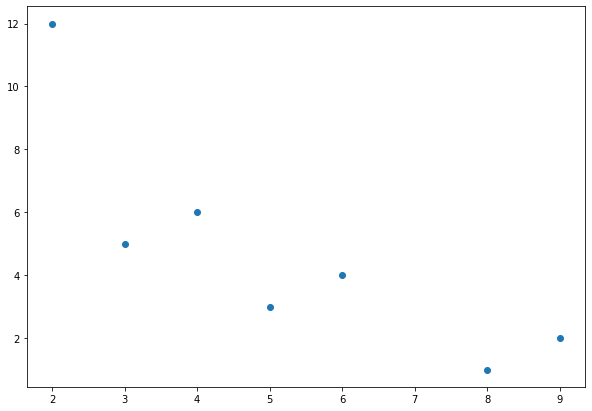

In [46]:
plt.rcParams.update({'figure.figsize': (10, 7)})
overlap_counter = Counter()
for person in overlap:
    overlap_counter.update([round(len(P.edges(person))/ len(G.edges(person)),0)])
    print(person, len(P.edges(person)), len(G.edges(person)), round(len(P.edges(person))/ len(G.edges(person)),1))
    
plt.scatter(overlap_counter.keys(),overlap_counter.values());

p004 7 1 7.0 [11]
p005 7 1 7.0 [14]
p006 7 1 7.0 [0]
p007 5 1 5.0 [26]
p015 12 1 12.0 [0]
p018 6 1 6.0 [22]
p021 6 2 3.0 [39]
p024 5 1 5.0 [24]
p025 5 1 5.0 [24]
p029 6 1 6.0 [19]
p030 4 1 4.0 [38]
p032 4 1 4.0 [41]
p035 4 1 4.0 [41]
p039 4 1 4.0 [42]
p043 4 1 4.0 [59]
p044 8 1 8.0 [7]
p046 7 2 3.5 [46]
p048 7 2 3.5 [11]
p051 13 6 2.17 [16]
p053 4 1 4.0 [53]
p055 4 1 4.0 [61]
p058 8 2 4.0 [22]
p059 17 1 17.0 [1]
p061 7 1 7.0 [12]
p066 8 1 8.0 [8]
p069 4 1 4.0 [40]
p070 4 1 4.0 [40]
p073 17 2 8.5 [0]
p074 25 7 3.57 [1]
p076 12 1 12.0 [4]
p080 8 1 8.0 [7]
p081 11 1 11.0 [5]
p082 16 3 5.33 [5]
p084 4 1 4.0 [36]
p088 14 8 1.75 [31]
p091 7 1 7.0 [13]
p095 12 1 12.0 [4]
p097 17 2 8.5 [0]
p098 14 1 14.0 [2]
p100 5 1 5.0 [27]
p101 7 2 3.5 [27]
p106 14 3 4.67 [6]
p110 5 1 5.0 [30]
p111 5 1 5.0 [30]
p113 4 1 4.0 [37]
p115 12 9 1.33 [51]
p122 8 1 8.0 [9]
p124 7 1 7.0 [10]
p128 18 6 3.0 [1]
p130 8 1 8.0 [8]
p131 9 4 2.25 [10]
p133 4 1 4.0 [43]
p134 4 1 4.0 [43]
p136 6 1 6.0 [21]
p149 14 1 14.0 [2]

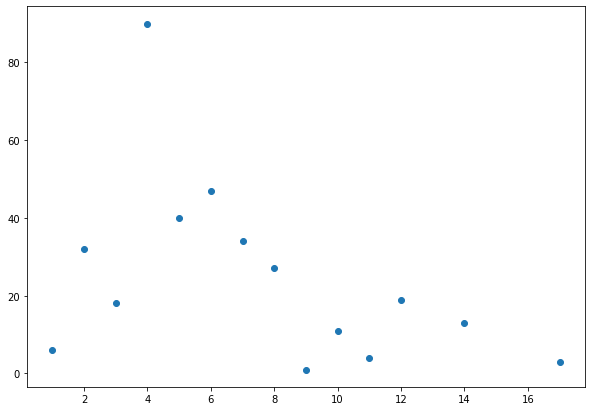

In [51]:
notoverlap_counter = Counter()

for person in notoverlap:
    notoverlap_counter.update([round(len(P.edges(person))/ len(G.edges(person)),0)])
    print(person, len(P.edges(person)), len(G.edges(person)), round(len(P.edges(person))/ len(G.edges(person)),2), nx.get_node_attributes(G, 'Community')[person])

plt.scatter(notoverlap_counter.keys(),notoverlap_counter.values());

p001 4 4 1.0
p003 1 1 1.0
p008 3 1 3.0
p009 3 1 3.0
p011 3 1 3.0
p012 8 3 2.67
p013 3 1 3.0
p014 3 1 3.0
p016 3 1 3.0
p019 3 1 3.0
p020 3 1 3.0
p022 1 1 1.0
p023 2 1 2.0
p026 3 1 3.0
p027 2 1 2.0
p028 3 1 3.0
p033 1 2 0.5
p034 1 1 1.0
p036 3 1 3.0
p038 2 1 2.0
p040 3 2 1.5
p041 3 2 1.5
p042 3 1 3.0
p047 2 1 2.0
p049 2 1 2.0
p052 1 1 1.0
p060 3 1 3.0
p063 1 1 1.0
p064 3 1 3.0
p065 1 1 1.0
p067 2 4 0.5
p068 1 1 1.0
p071 2 1 2.0
p072 2 1 2.0
p075 3 1 3.0
p077 2 2 1.0
p079 3 6 0.5
p083 1 1 1.0
p085 1 1 1.0
p086 3 1 3.0
p087 1 4 0.25
p089 2 3 0.67
p090 2 1 2.0
p092 3 1 3.0
p093 1 1 1.0
p096 1 1 1.0
p099 1 1 1.0
p102 2 1 2.0
p103 2 1 2.0
p105 3 1 3.0
p107 2 1 2.0
p108 7 6 1.17
p109 2 1 2.0
p112 5 4 1.25
p116 2 1 2.0
p117 2 2 1.0
p118 1 1 1.0
p119 3 2 1.5
p120 1 1 1.0
p121 3 1 3.0
p123 2 1 2.0
p125 2 1 2.0
p126 1 1 1.0
p129 5 5 1.0
p132 1 1 1.0
p137 2 1 2.0
p138 1 1 1.0
p139 1 1 1.0
p142 1 1 1.0
p143 2 1 2.0
p144 2 1 2.0
p147 3 1 3.0
p148 2 1 2.0
p151 2 1 2.0
p155 3 5 0.6
p159 8 7 1.14
p160 2

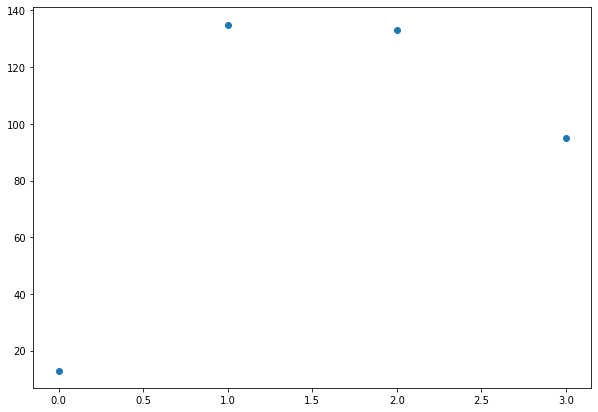

In [49]:
none_counter = Counter()

for person in none:
    none_counter.update([round(len(P.edges(person))/ len(G.edges(person)),0)])
    print(person, len(P.edges(person)), len(G.edges(person)), round(len(P.edges(person))/ len(G.edges(person)),2))

plt.scatter(none_counter.keys(),none_counter.values());